In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Connecting to Postgres¶
In order to set up the PostGres Database, we used docker-compose to build the jupyter and postgres containers. However, we run into the issue with data persistence as when the PostGres container goes down, the data within that container gets removed. And so we need to create a volume that houses all our data so that whenever our container goes down, the volume will hold all of it. And when the container comes back up, the volume will be operating in the container.

The diagram below shows the setup for this. Also running is our Jupyter notebook container for which this current notebook is running on.

<img src="other_assets/docker_postgres_setup.png" width="700">

In [2]:
!pip install psycopg2

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor

def execute_query(query):  
    connection = pg2.connect(host='postgres',
                             user='postgres',
                             database='basketball')
    cursor = connection.cursor(cursor_factory=RealDictCursor)
    cursor.execute(query)
    r = cursor.fetchall()
    cursor.close()
    return r

def query_to_df(query):
    df = pd.DataFrame(execute_query(query))
    return df

### EDA on Salary Cap

Going to take a look at the salary cap. Exploring this data to develop a problem statement. Knowing from recent events, NBA players' salaries have come under heavy scrutiny and it has become such a topic of dispute that it led to several NBA lockouts. Based on the data, it looks like the amount of money spent on NBA players has grown explosively - just based on salary cap alone.

In [4]:
salary_df = query_to_df('SELECT * FROM salary_cap;')

In [5]:
salary_df.head()

,salary_cap,salary_cap_2015_worth,year
0,3600000.0,7934034.0,1984-85
1,4233000.0,9153509.0,1985-86
2,4945000.0,10317292.0,1986-87
3,6164000.0,12354015.0,1987-88
4,7232000.0,13829137.0,1988-89


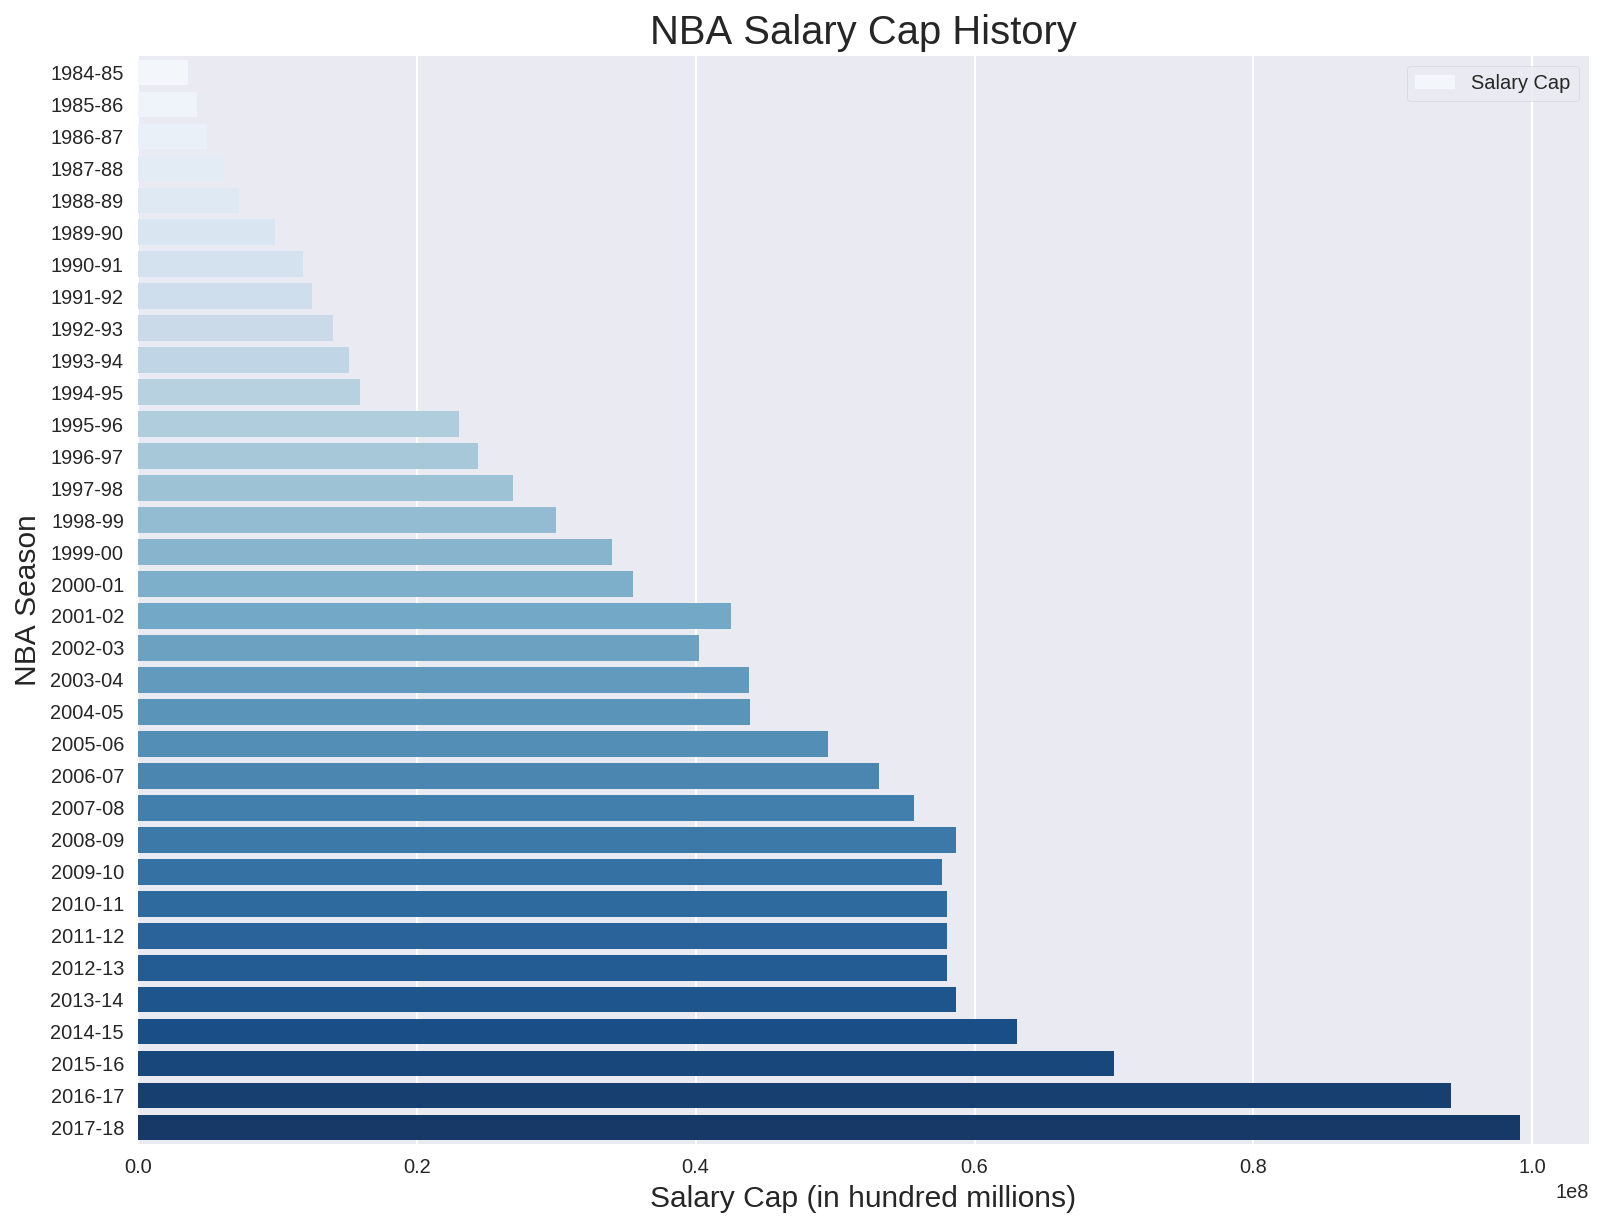

In [6]:
fig = plt.figure(figsize=(13,10)) 
ax = plt.gca()

sns.barplot(x='salary_cap', y='year', data=salary_df, label='Salary Cap',palette='Blues')

ax.set_title('NBA Salary Cap History',size=20)
ax.set_ylabel('NBA Season', fontsize=15)
ax.set_xlabel('Salary Cap (in hundred millions)', fontsize=15)

ax.legend(loc="upper right", frameon=True)
sns.despine(left=True, bottom=True)

### EDA on NBA Team Salaries

Exploring the data of how much money teams spend. Even though there is a salary cap, this is considered a "soft cap" in which it is a complex system of rules and exceptions. Many teams use these exceptions to be able to pay out players even more and allow teams to go beyond the already increasing desiganted salary cap. Gathering salaries for every player in the NBA and grouping them by team, let's see how much the payout is by team and how that compares to the salary cap.

In [7]:
team_sal_df = query_to_df('SELECT * FROM team_salary;')
team_sal_df.head()

,guaranteed,player,signed_using,team,year_five,year_four,year_one,year_three,year_two,year_zero
0,33285709.0,LeBron James,Early Bird,CLE,0.0,0.0,35607968.0,0.0,0.0,33285709.0
1,46761375.0,Kevin Love,Bird Rights,CLE,0.0,0.0,24119025.0,0.0,25595700.0,22642350.0
2,52408695.0,Tristan Thompson,Bird Rights,CLE,0.0,0.0,17469565.0,0.0,18539130.0,16400000.0
3,32350000.0,J.R. Smith,Bird Rights,CLE,0.0,0.0,14720000.0,0.0,15680000.0,13760000.0
4,10337079.0,Iman Shumpert,Bird Rights,CLE,0.0,0.0,11011234.0,0.0,0.0,10337079.0


In [8]:
team_sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 10 columns):
guaranteed      514 non-null float64
player          514 non-null object
signed_using    514 non-null object
team            514 non-null object
year_five       514 non-null float64
year_four       514 non-null float64
year_one        514 non-null float64
year_three      514 non-null float64
year_two        514 non-null float64
year_zero       514 non-null float64
dtypes: float64(7), object(3)
memory usage: 40.2+ KB


In [9]:
team_total = team_sal_df[['team','year_zero']].groupby('team').sum()
team_total.reset_index(inplace=True)
team_total.head()

,team,year_zero
0,ATL,94963111.0
1,BOS,111558063.0
2,BRK,95643736.0
3,CHI,78417155.0
4,CHO,118947949.0


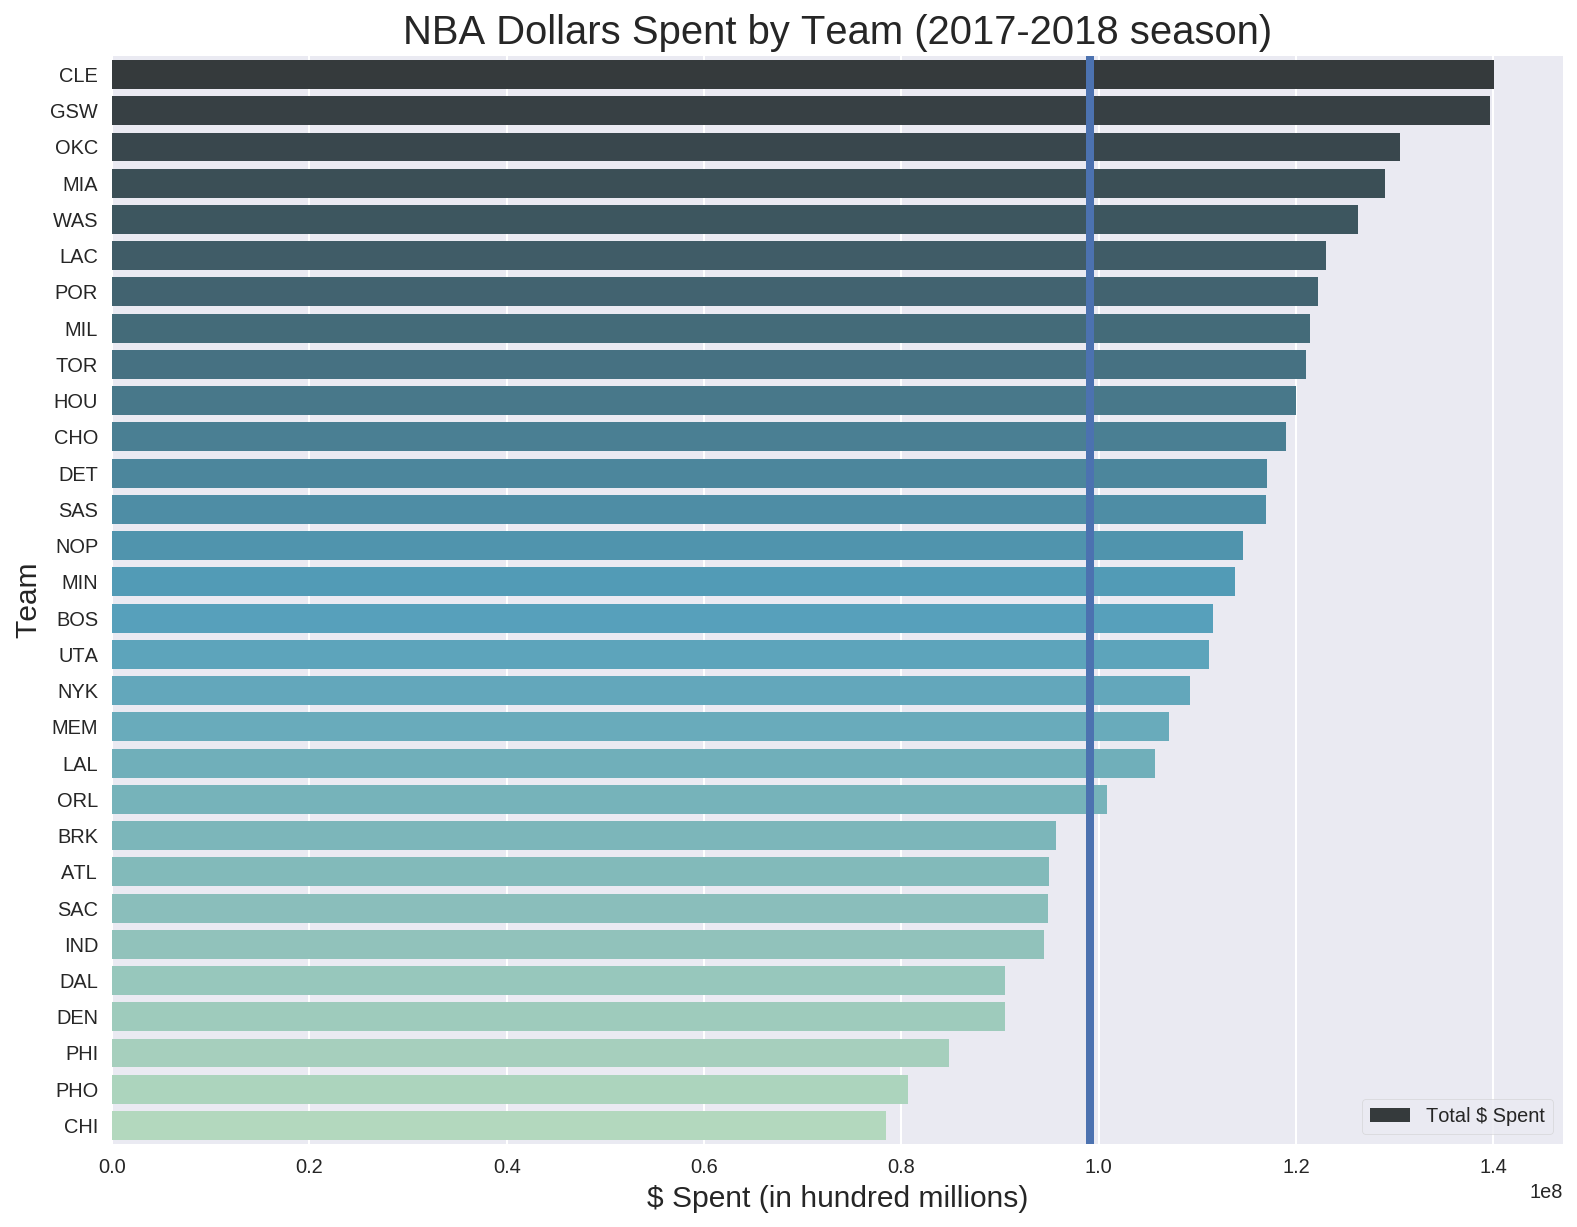

In [10]:
fig = plt.figure(figsize=(13,10)) 
ax = plt.gca()

sns.barplot(x='year_zero', y='team', data=team_total.sort_values('year_zero',ascending=False), label='Total $ Spent',palette='GnBu_d')

ax.legend(loc="lower right", frameon=True)
ax.set_title('NBA Dollars Spent by Team (2017-2018 season)',size=20)
ax.set_ylabel('Team', fontsize=15)
ax.set_xlabel('$ Spent (in hundred millions)', fontsize=15)

sns.despine(left=True, bottom=True)
plt.plot([99093000, 99093000], [100, -1], linewidth=4)
plt.show()

### EDA on Salary Spread

Not only has there been explosive growth in the amount money spent on NBA players, but there also seems to be a huge earnings gap for each individual players with clear outliers on the top. This seems to be the trend for every team. Developing a plot below to show this.

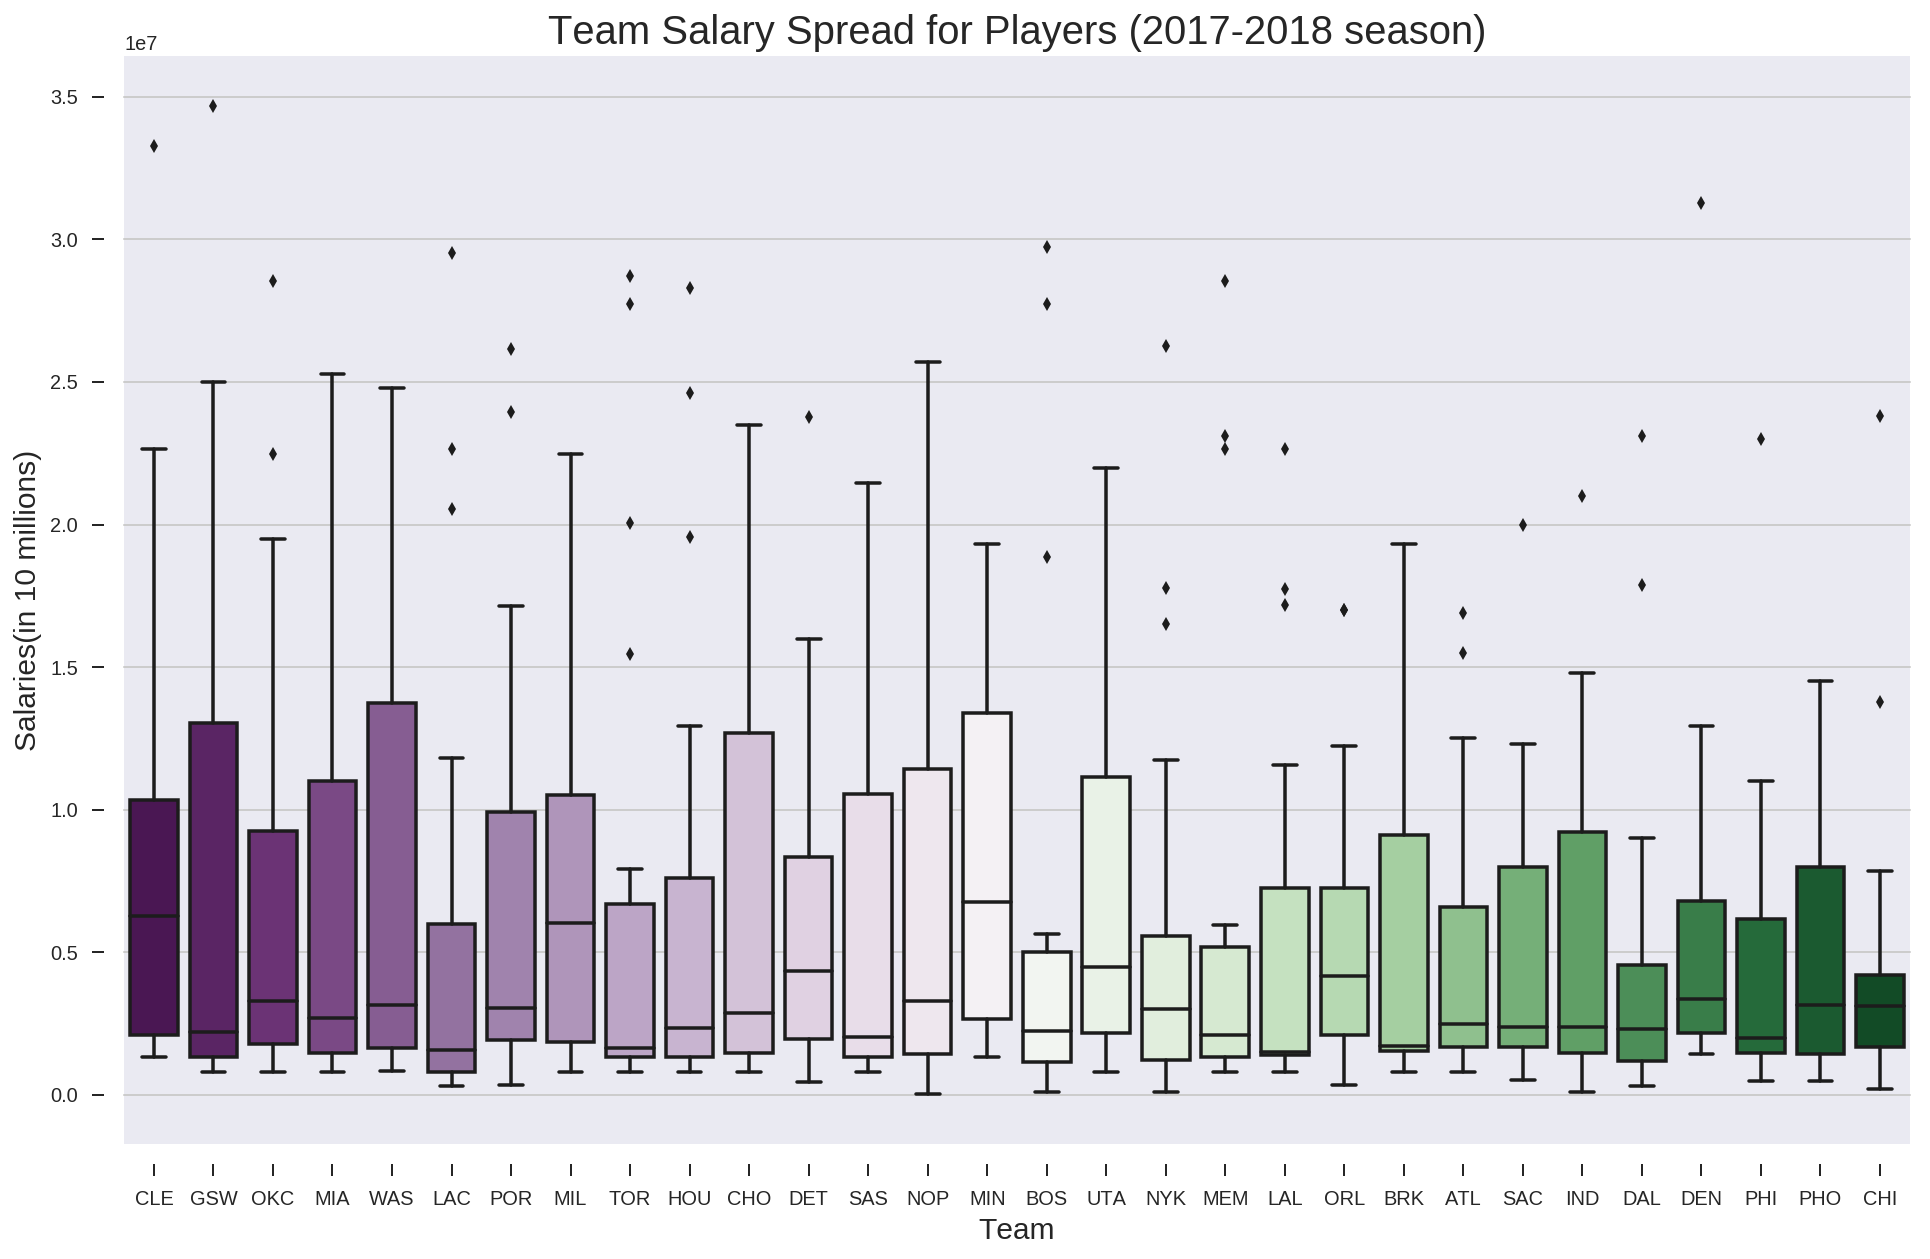

In [11]:
team_box = team_sal_df[['team','year_zero']]

fig = plt.figure(figsize=(16,10)) 
ax = plt.gca()

sns.set(style="ticks")
sns.boxplot(x="team", y="year_zero", data=team_box, palette="PRGn")

ax.set_title('Team Salary Spread for Players (2017-2018 season)',size=20)
ax.set_ylabel('Salaries(in 10 millions)', fontsize=15)
ax.set_xlabel('Team', fontsize=15)

sns.despine(offset=10, trim=True)

In [12]:
team_sal_df.describe()

,guaranteed,year_five,year_four,year_one,year_three,year_two,year_zero
count,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02,5.140000e+02
mean,1.422262e+07,1.880959e+05,4.017553e+05,5.595186e+06,1.819963e+06,3.929540e+06,6.429708e+06
std,2.486012e+07,2.923282e+06,3.979132e+06,7.818813e+06,6.338897e+06,7.781787e+06,7.288537e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+04
25%,1.471382e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.467286e+06
50%,3.565646e+06,0.000000e+00,0.000000e+00,1.810658e+06,0.000000e+00,0.000000e+00,2.925892e+06
75%,1.625238e+07,0.000000e+00,0.000000e+00,7.963403e+06,0.000000e+00,3.240000e+06,9.225694e+06
max,2.011588e+08,4.687200e+07,4.578097e+07,3.745715e+07,4.300636e+07,4.023176e+07,3.468255e+07


### EDA on 2016-2017 NBA player stats and salaries

Now let's start doing some exploratory data analysis on the main table for our model below. We saw a pretty wide spread from the box plot above. Let's take a look at the distribution of salaries last NBA season. It'll probably show a skew distribution with more players getting paid less.

In [13]:
nba_df = query_to_df('SELECT * FROM nba_2016')
nba_df.head()

,age,all_star,ast,blk,college,draft_position,draft_year,drb,efg_perc,fg,...,three_att,three_p,three_perc,tov,trb,two_att,two_p,two_perc,weight_lbs,ws
0,24,0,4.0,13.0,Purdue University,46,2016,28.0,0.464,17.0,...,10.0,5.0,0.500,10.0,36.0,32.0,12.0,0.375,260.0,0.0
1,32,0,125.0,9.0,University of Oregon,26,2007,51.0,0.483,121.0,...,128.0,48.0,0.375,66.0,69.0,172.0,73.0,0.424,161.0,0.3
2,21,0,150.0,40.0,University of Arizona,4,2014,289.0,0.499,393.0,...,267.0,77.0,0.288,89.0,405.0,598.0,316.0,0.528,220.0,3.7
3,22,0,3.0,0.0,University of Kentucky,0,0,3.0,0.000,0.0,...,2.0,0.0,0.000,0.0,3.0,2.0,0.0,0.000,210.0,0.1
4,25,0,7.0,7.0,Michigan State University,15,2014,24.0,0.454,23.0,...,15.0,3.0,0.200,8.0,33.0,39.0,20.0,0.513,237.0,0.2


In [14]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 39 columns):
age               486 non-null int64
all_star          486 non-null int64
ast               486 non-null float64
blk               486 non-null float64
college           486 non-null object
draft_position    486 non-null int64
draft_year        486 non-null int64
drb               486 non-null float64
efg_perc          485 non-null float64
fg                486 non-null float64
fg_perc           485 non-null float64
fga               486 non-null float64
ft                486 non-null float64
ft_perc           471 non-null float64
fta               486 non-null float64
g                 486 non-null float64
gs                486 non-null float64
height_inches     486 non-null float64
mp                486 non-null float64
orb               486 non-null float64
per               486 non-null float64
pf                486 non-null float64
player            486 non-null object
position

We saw a pretty wide spread from the box plot above. Let's take a look at the distribution of salaries last NBA season. It'll probably show a skew distribution with more players getting paid less.

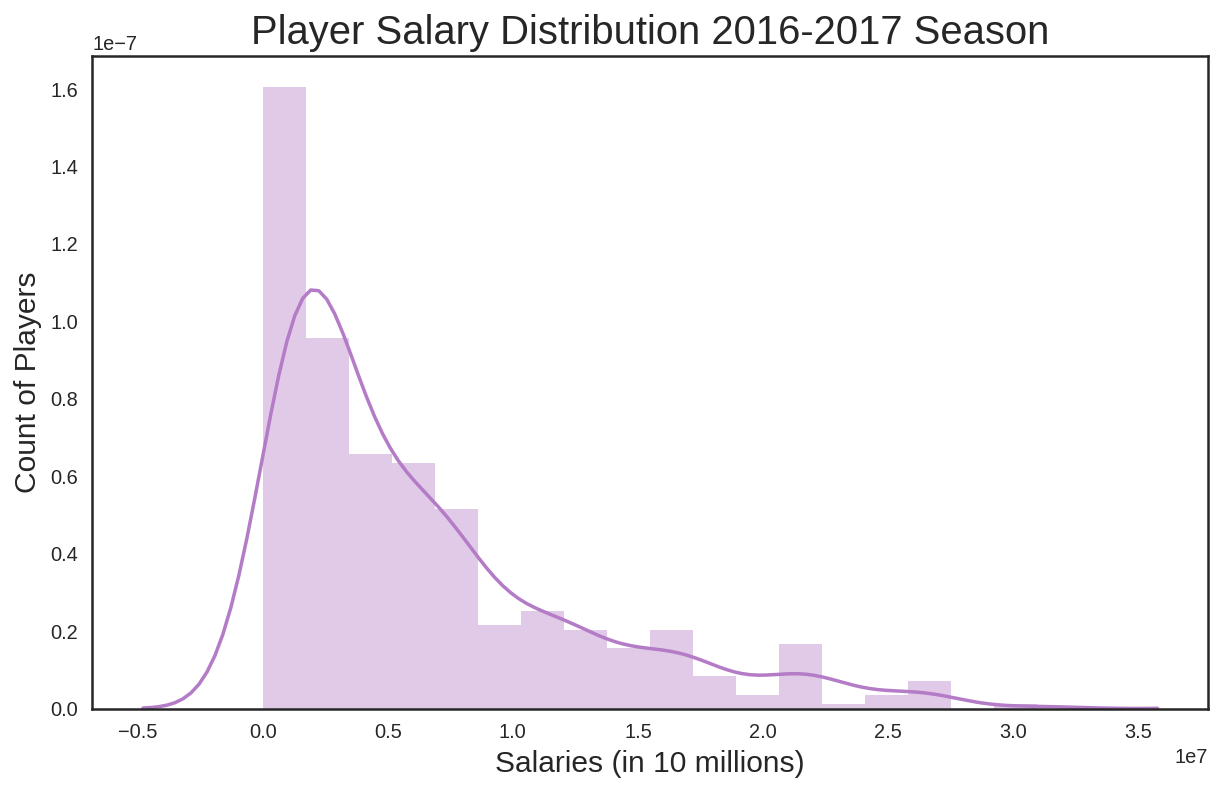

In [19]:
fig = plt.figure(figsize=(10,6)) 
ax = plt.gca()

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(nba_df['salary'], color="m")

ax.set_title('Player Salary Distribution 2016-2017 Season',size=20)
ax.set_ylabel('Count of Players', fontsize=15)
ax.set_xlabel('Salaries (in 10 millions)', fontsize=15)
plt.show()

I'm wondering if a player's age has anything to do with their salaries. There is probably a peak somewhere in the middle range as player's in the prime of their physical performence will be beyond their rookie years but will be younger than players who are near retirement

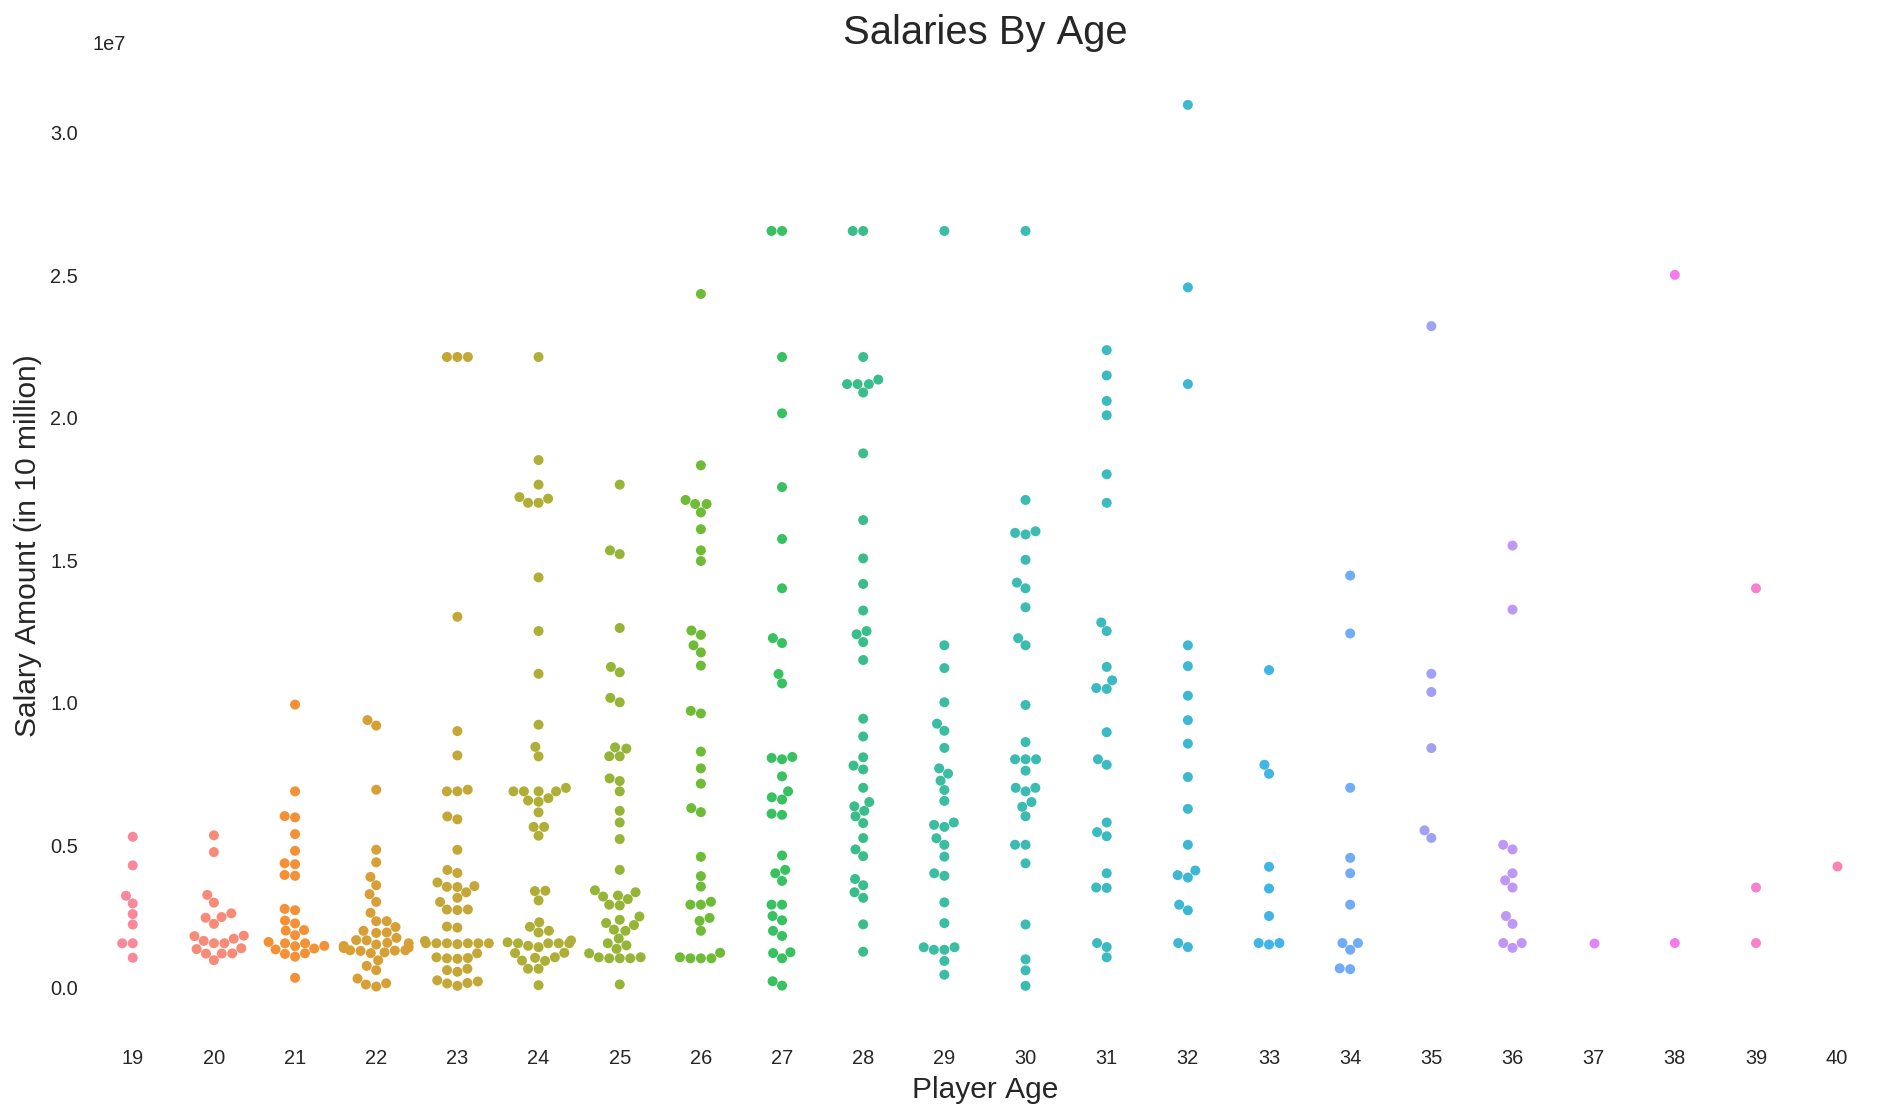

In [16]:
fig = plt.figure(figsize=(16,9)) 
ax = plt.gca()

sns.swarmplot(x='age', y='salary', data=nba_df.sort_values('age',ascending=False))

ax.set_title('Salaries By Age',size=20)
ax.set_ylabel('Salary Amount (in 10 million)', fontsize=15)
ax.set_xlabel('Player Age', fontsize=15)

sns.despine(left=True, bottom=True)
plt.show()

That's kind of interesting. It looks like around the ages of 28-33 is when we see the really high salaries. It looks like there are large grouping of players who are much younger (in the 20-23 range) who have significantly lower salaries than the rest. I think this might be due to the fact younger players are more likely to be in their rookie contracts. Usually, players' salaries are are constrained by the rookie salary cap which is typically in force for three years - which is shown in that ages 20-23 had the lowest salaries.

Let's take a look at this based on season count.

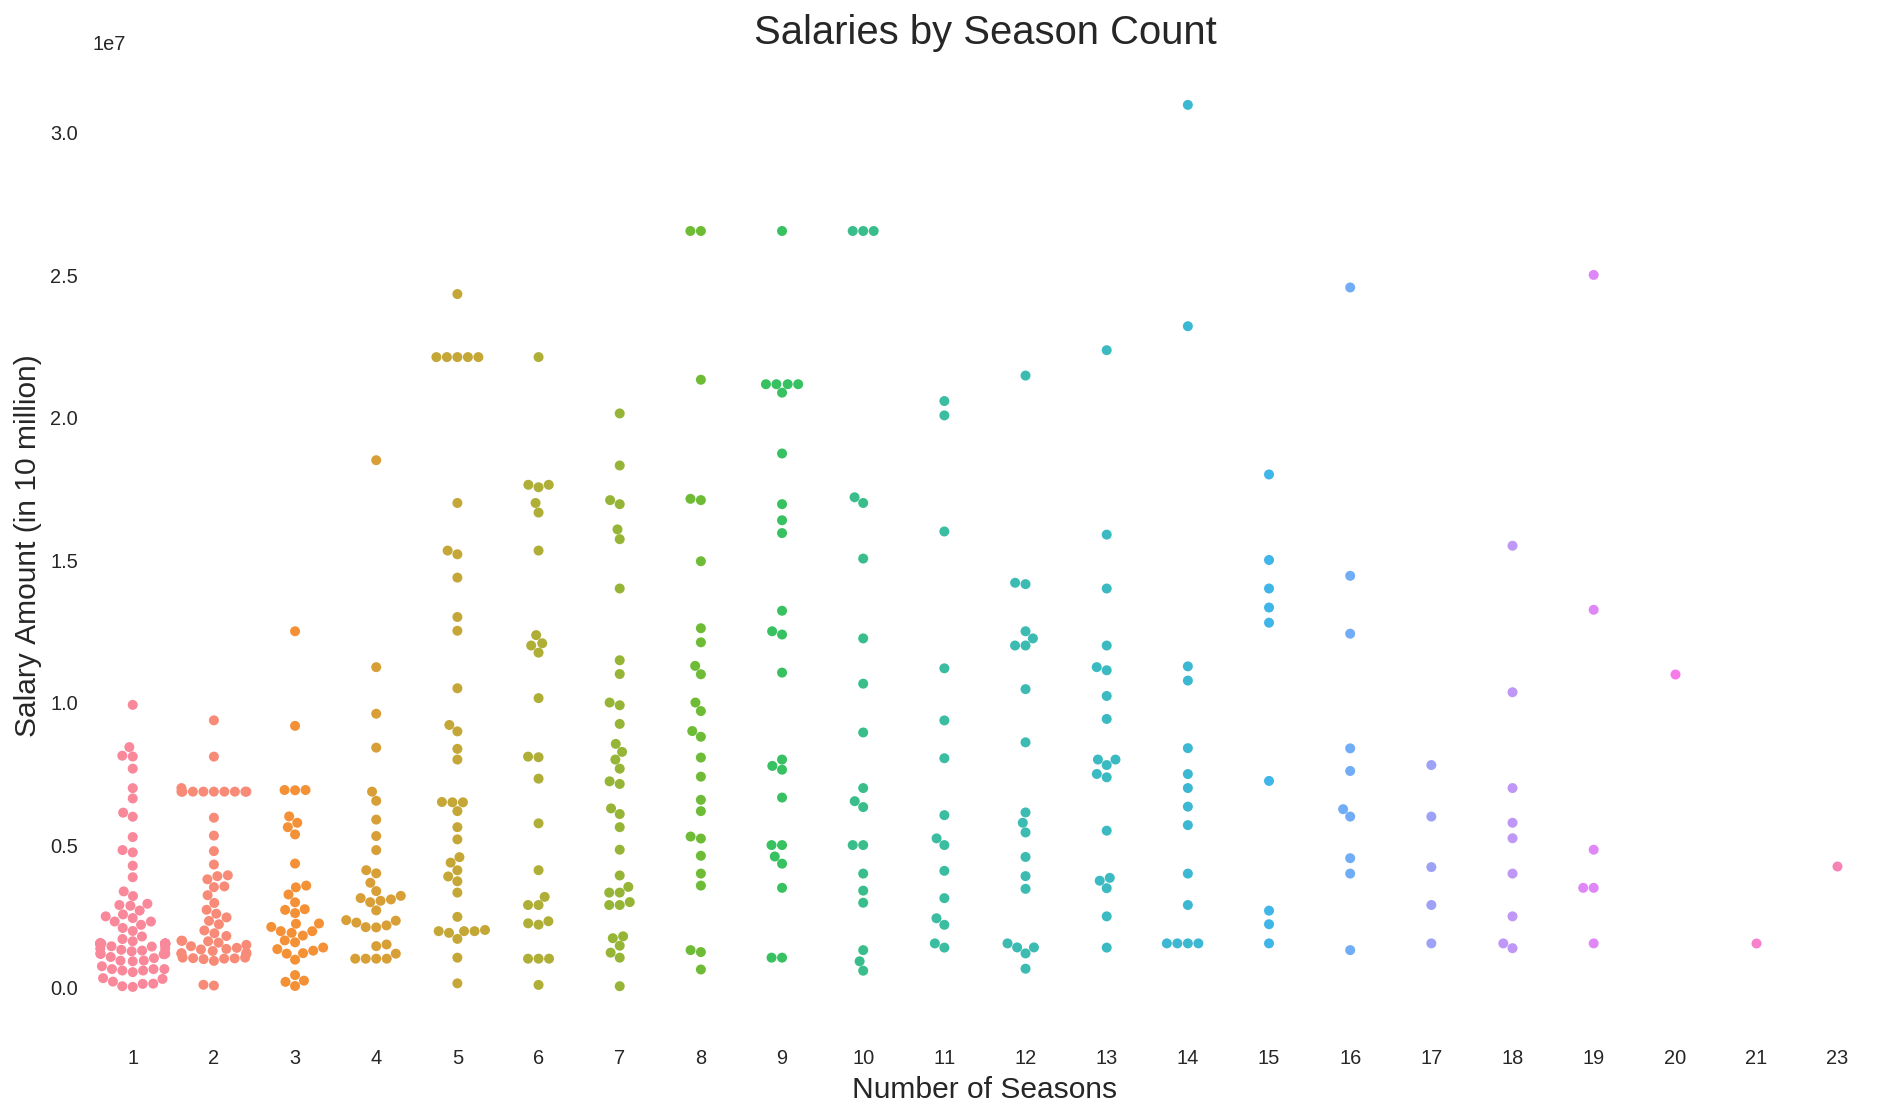

In [17]:
fig = plt.figure(figsize=(16,9)) 
ax = plt.gca()

sns.swarmplot(x='season_count', y='salary', data=nba_df.sort_values('age',ascending=False))

ax.set_title('Salaries by Season Count',size=20)
ax.set_ylabel('Salary Amount (in 10 million)', fontsize=15)
ax.set_xlabel('Number of Seasons', fontsize=15)

sns.despine(left=True, bottom=True)
plt.show()

The swarm grew even larger at the first 3 year mark - it definitely seems that it's an affect of the rookie contract constraint. Given 

#### All-Star Status
Taking a look at whether being an NBA All Star has an affect on salaries.

In [18]:
all_star_comparison = nba_df[['all_star','salary']]
all_star_comparison['all_star'] = all_star_comparison.all_star.map(lambda x: 'Not All-Star' if x == 0 else 'All-Star')
all_star_comparison.head()

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,all_star,salary
0,Not All-Star,650000.0
1,Not All-Star,2700000.0
2,Not All-Star,4351320.0
3,Not All-Star,9375579.0
4,Not All-Star,2022240.0


In [28]:
all_star = all_star_comparison[all_star_comparison['all_star']=='All-Star']
not_star = all_star_comparison[all_star_comparison['all_star']=='Not All-Star']

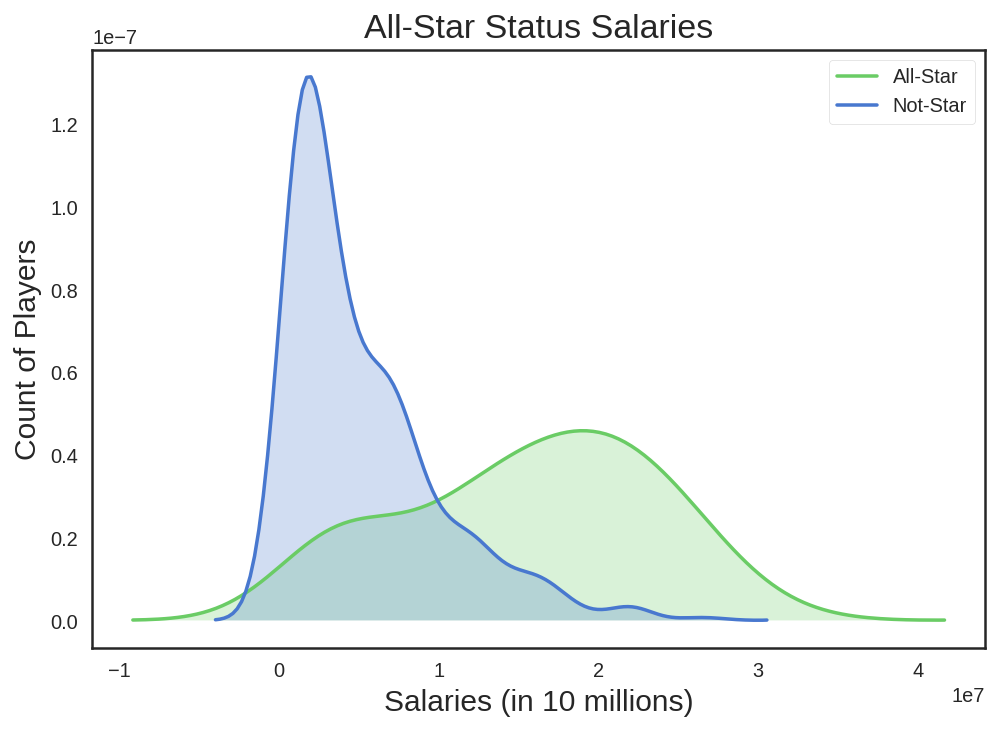

In [27]:
fig, ax = plt.subplots()

sns.set(style="white", palette="muted", color_codes=True)
sns.distplot(all_star['salary'], hist=False, color="g", kde_kws={"shade": True},ax=ax,label='All-Star')
sns.distplot(not_star['salary'], hist=False, color="b", kde_kws={"shade": True},ax=ax,label='Not-Star')

ax.set_title('All-Star Status Salaries',size=17)
ax.set_ylabel('Count of Players', fontsize=15)
ax.set_xlabel('Salaries (in 10 millions)', fontsize=15)
ax.legend(loc="upper right", frameon=True)
plt.show()

This is an interesting plot as it shows that there is some overlap with players who are all stars and those who are not. I am guessing that the lower rung of the all-star salaries are probably those who are older and not as able to play like they used to. Going to see below.

In [37]:
all_stars = nba_df[nba_df['all_star'] == 1]
all_stars.sort_values('salary',ascending=True)[['player','season_count','salary']].head(10)

,player,season_count,salary
101,David Lee,14,1551659.0
103,David West,14,1551659.0
325,Metta World Peace,21,1551659.0
160,Giannis Antetokounmpo,4,2995421.0
373,Paul Pierce,19,3500000.0
122,Devin Harris,17,4228000.0
471,Vince Carter,23,4264057.0
190,Jameer Nelson,16,4540525.0
400,Roy Hibbert,11,5000000.0
278,Kyle Korver,18,5239437.0


#### Salary by Position

Another thing that I wanted to explore was to see if a player's position had any kind of affect on salary. It might show a general trend in the game of basketball if there are certain positions that teams are willing to pay more money for

In [38]:
pos_comparison = nba_df[['position','salary']].groupby('position').mean()
pos_comparison.reset_index(inplace=True)
pos_comparison

,position,salary
0,C,6.983705e+06
1,PF,6.179926e+06
2,PG,6.545569e+06
3,SF,6.454252e+06
4,SG,5.917246e+06


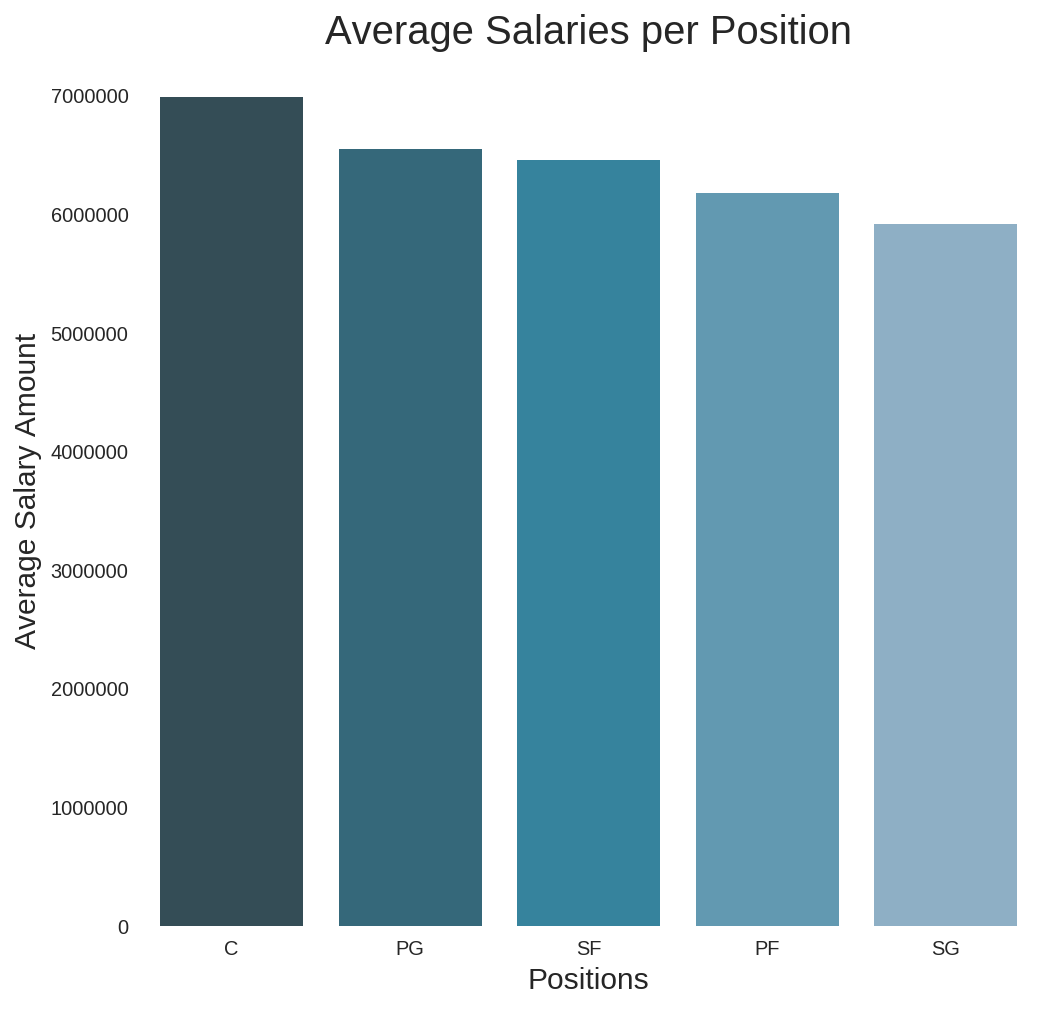

In [39]:
fig = plt.figure(figsize=(8,8)) 
ax = plt.gca()

sns.barplot(x='position', y='salary',data=pos_comparison.sort_values('salary',ascending=False), palette='PuBuGn_d')

ax.set_title('Average Salaries per Position',size=20)
ax.set_ylabel('Average Salary Amount', fontsize=15)
ax.set_xlabel('Positions', fontsize=15)

sns.despine(left=True, bottom=True)
plt.show()

There are some positions that seem to get paid more than others but there really isn't that much of a difference. When it comes to predicting salaries, it doesn't seem that position will have very much of an effect. But this does lead me to think that perhaps there are players who take on multiple positions that are on the higher-ends of the salary level. This is something that I would like to try to conduct some unsupervised learning on.

#### Correlations amongst statistic variables

Now going to see if there are any relationships or correlation amongst the statistics as we need to be sure that they are indepenent of one another. There are some statastical categories that are actually counting the same thing - for example, offensive rebounds, defensive rebounds which are summing to the total rebounds. These would affect the model because such statistics would be counted twice while others may not be.

To find these correlations, we use a heatmap

In [42]:
stats_df = nba_df[[
    'g',
    'gs',
    'mp',
    'fg',
    'fga',
    'fg_perc',
    'three_p',
    'three_att',
    'three_perc',
    'two_p',
    'two_att',
    'two_perc',
    'efg_perc',
    'ft',
    'fta',
    'ft_perc',
    'orb',
    'drb',
    'trb',
    'ast',
    'stl',
    'blk',
    'tov',
    'pf',
    'pts',
    'per',
    'ws',
    'salary'
]]

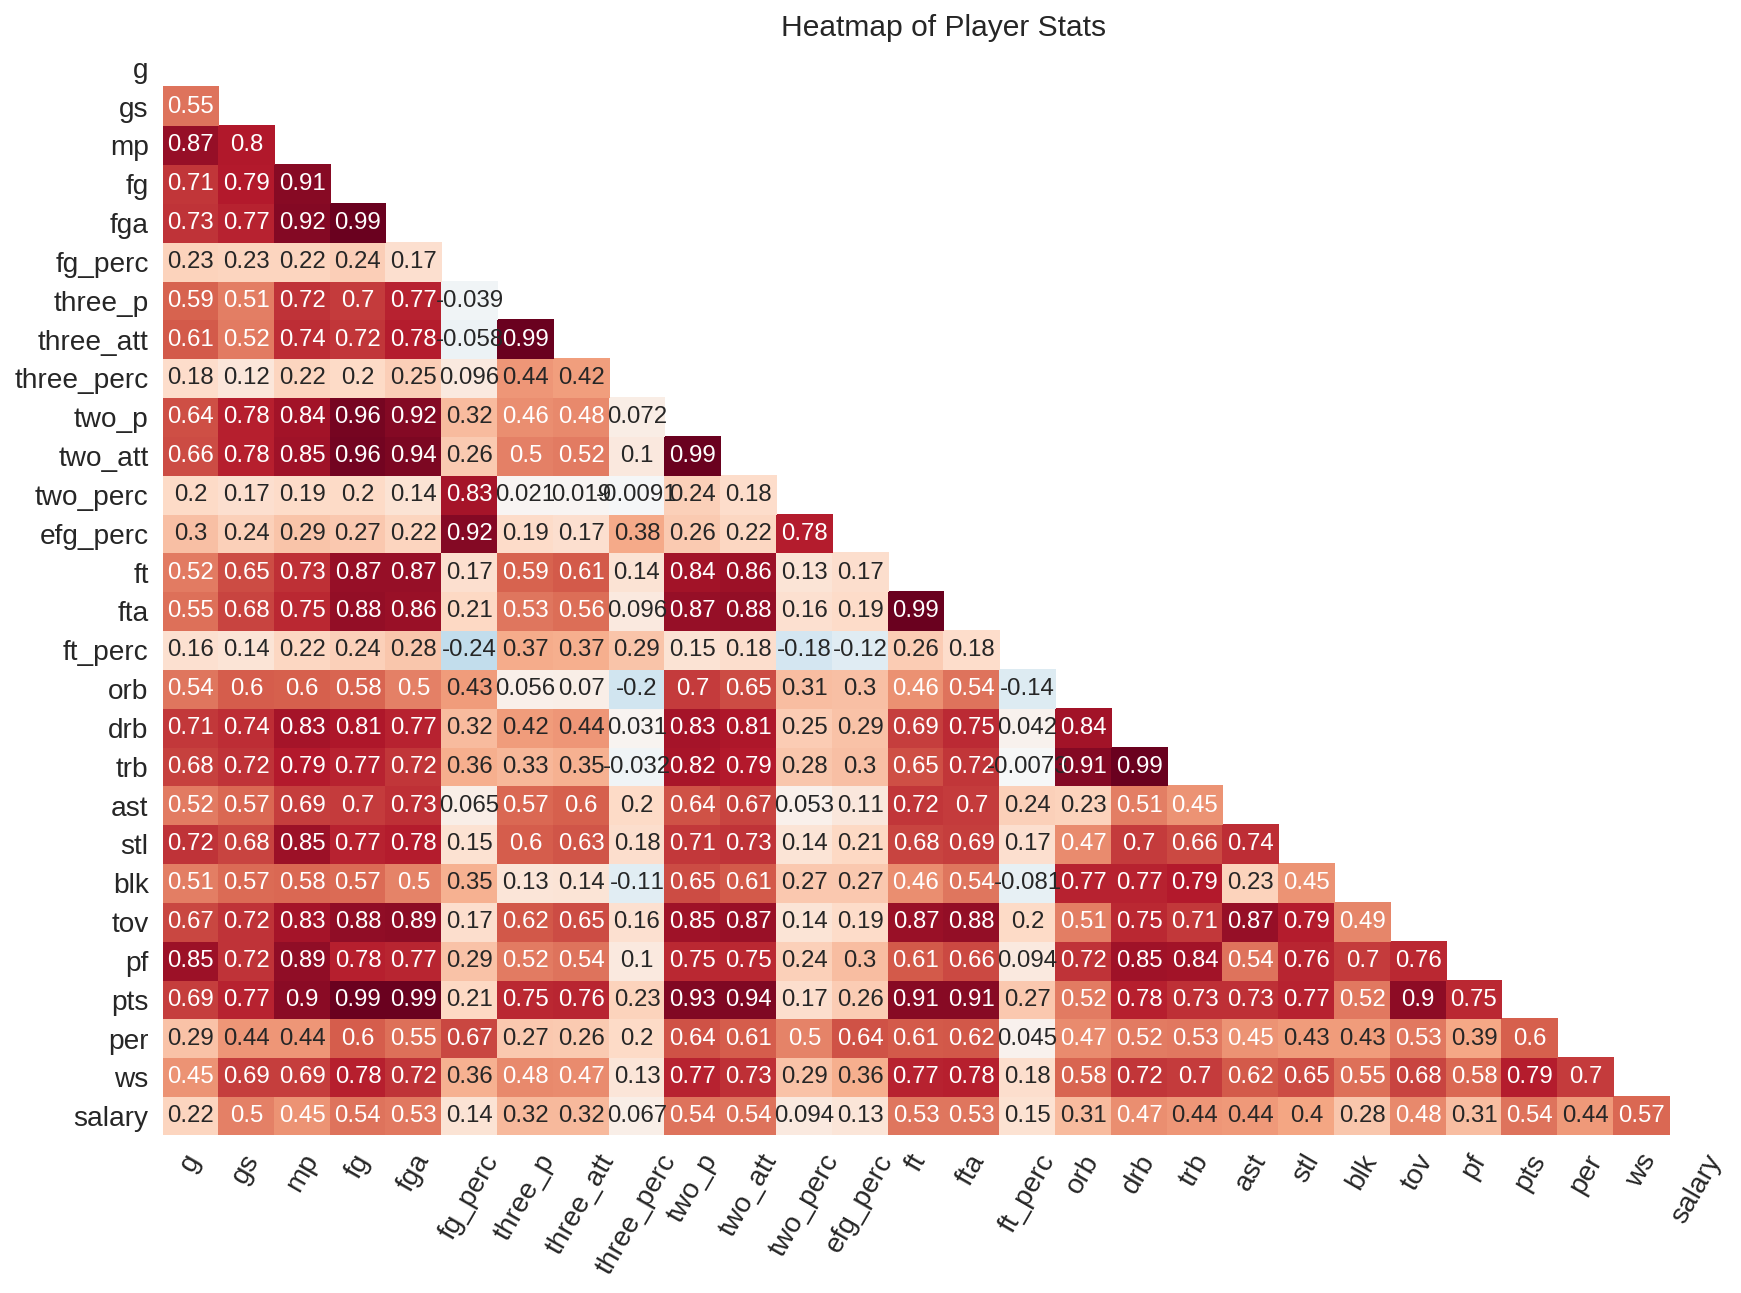

In [48]:
corrs = stats_df.corr()

fig, ax = plt.subplots(figsize = (14, 10))
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
  
ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=60)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
ax.set_title("Heatmap of Player Stats", size=15)

plt.show()

#### Looking at salaries based on Win-Shares and Player Effeciency Rating

One of the other things that I wanted to look at was which player produced the most win-shares and if their salaries showed for that.

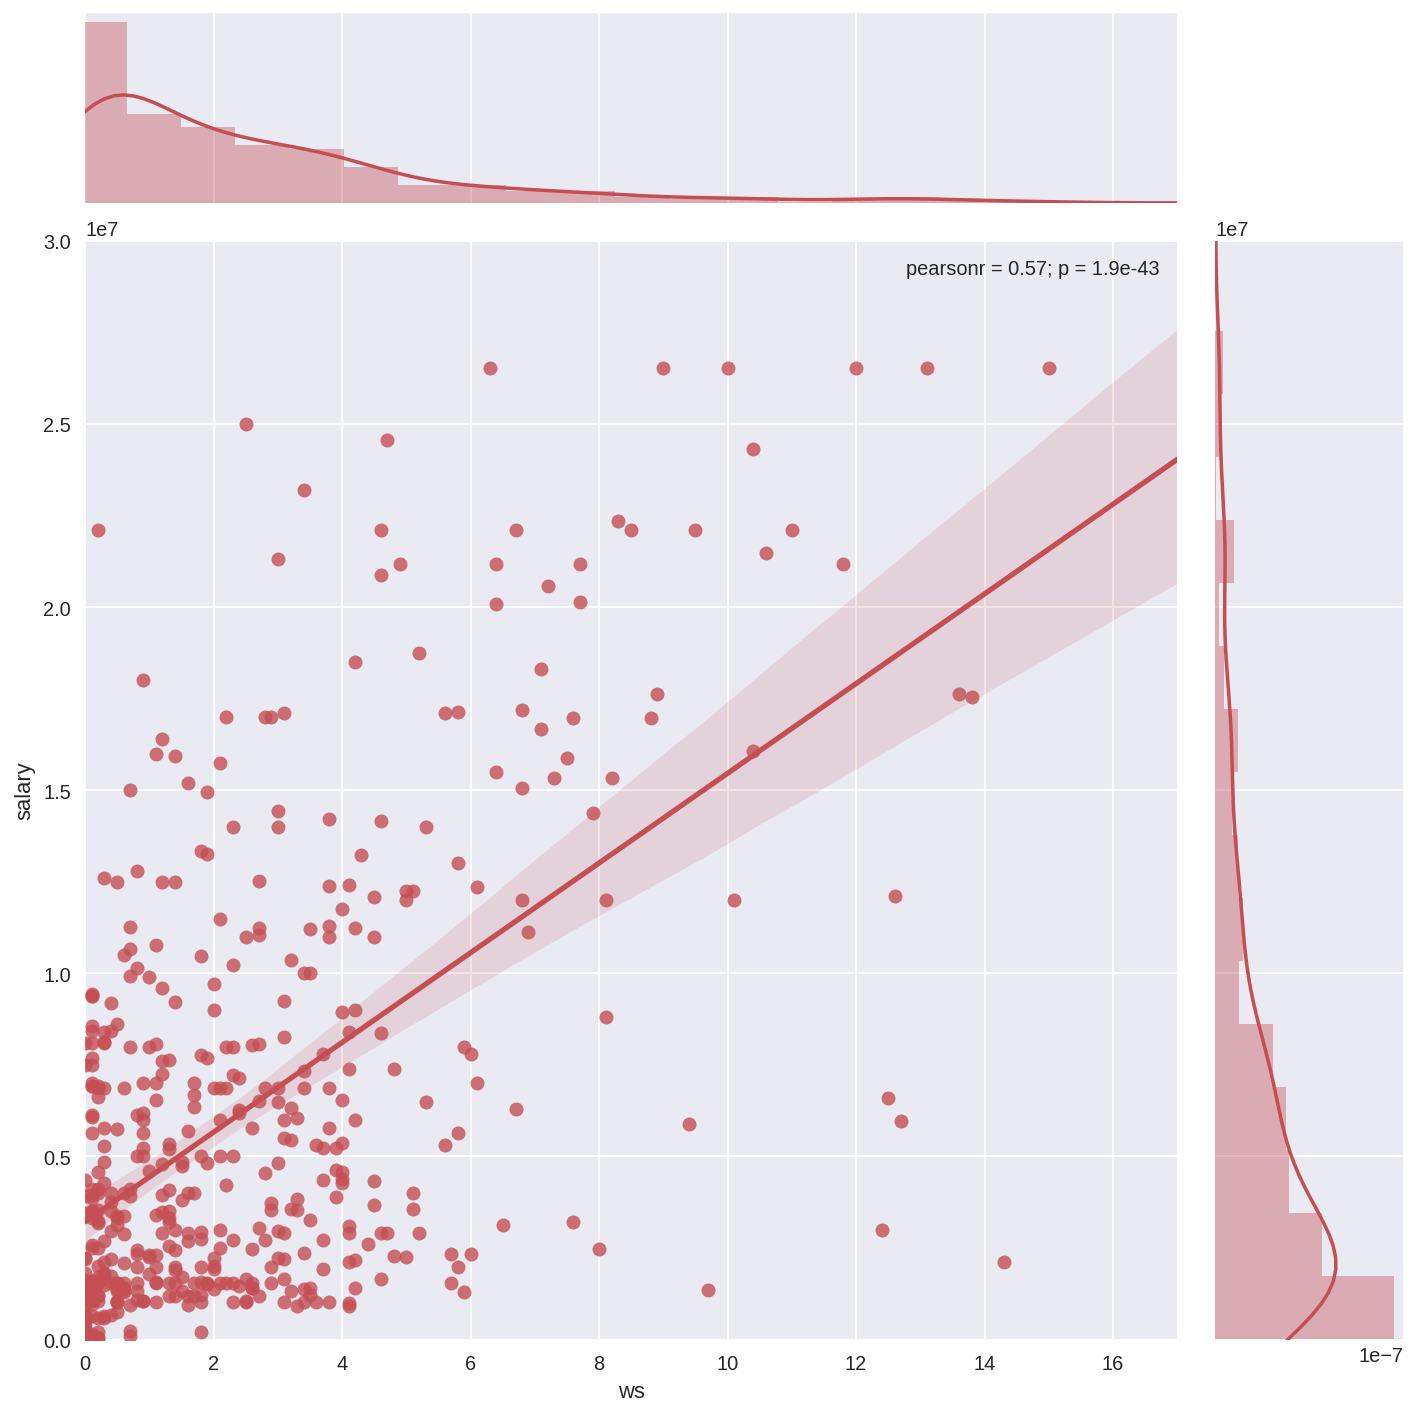

In [67]:
win_shares = nba_df[['ws','salary']]
sns.set(style="darkgrid", color_codes=True)

sns.jointplot('ws', "salary", data=win_shares, kind="reg",
                  xlim=(0, 17), ylim=(0, 30000000), color="r", size=10)

plt.show()

The same graph below shows salary by player efficiency rating, which is another statistic that measures player's performence. It's a measure of per-minute production standardized such that the league average is 15.

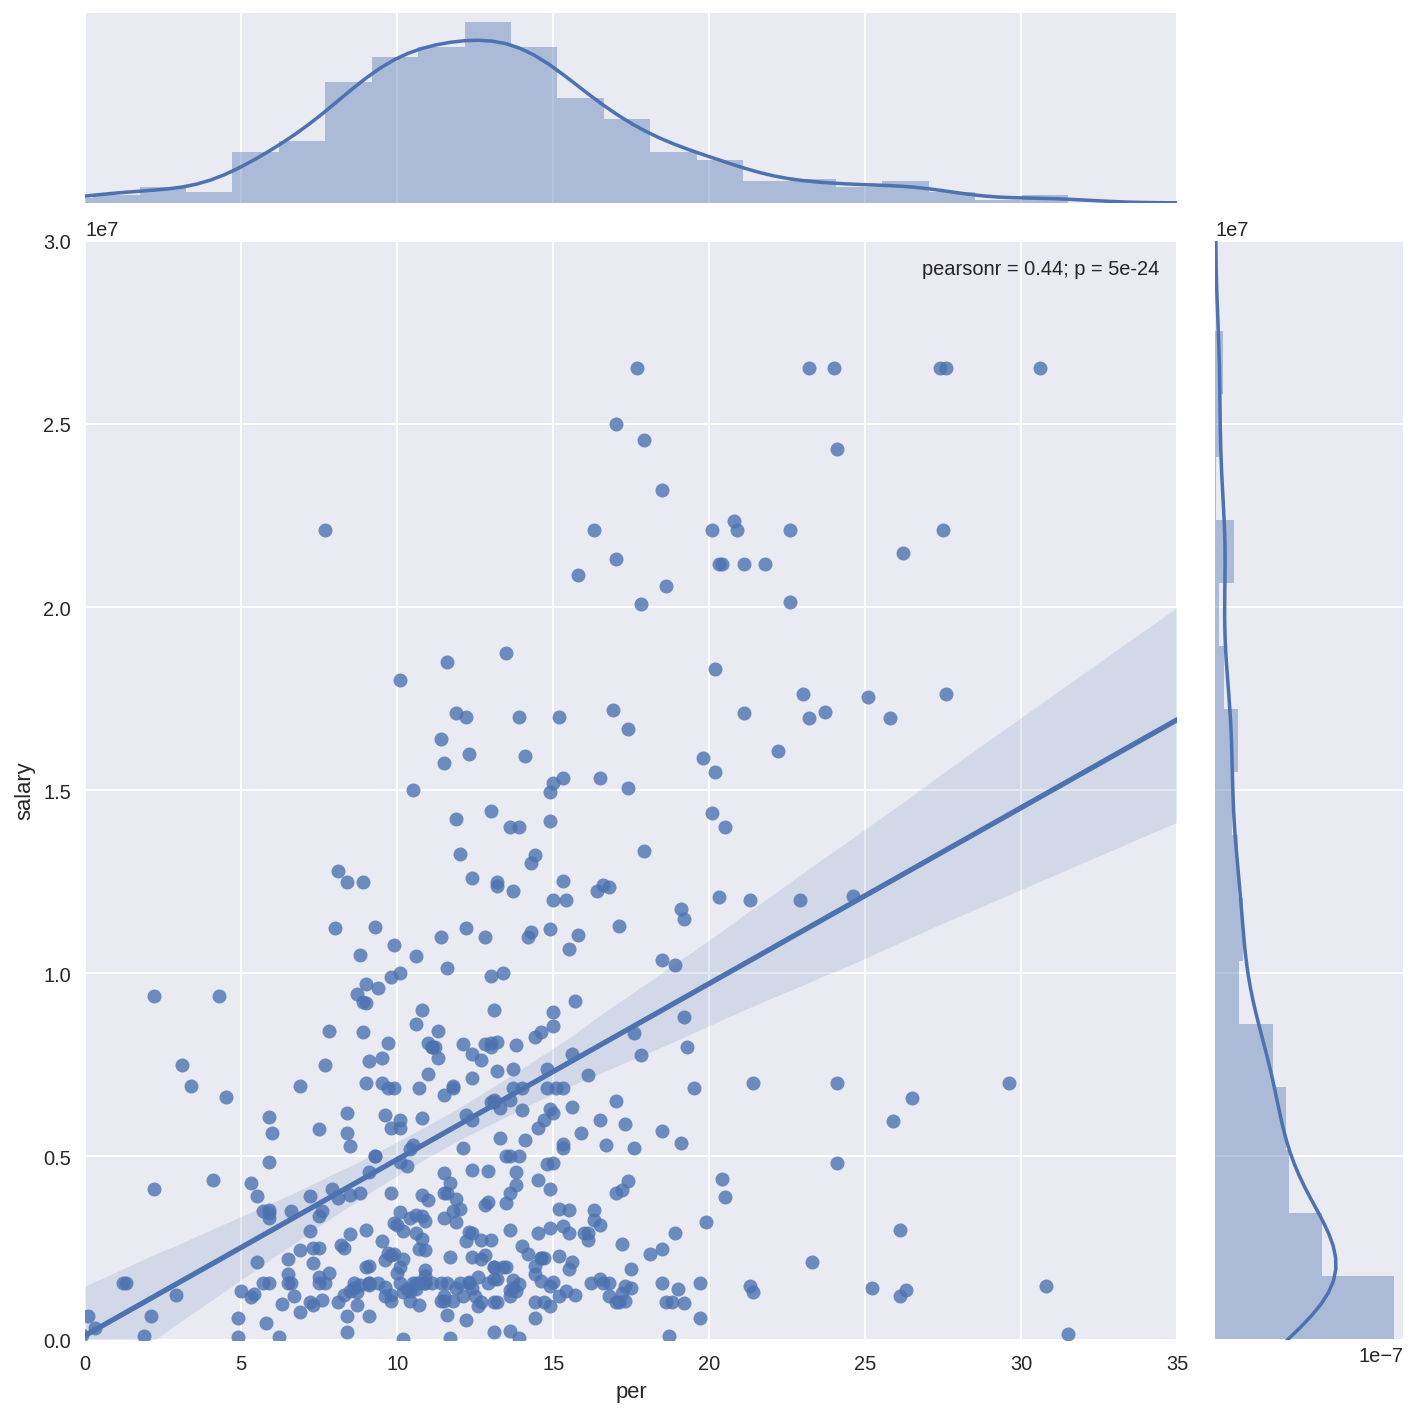

In [68]:
per_df = nba_df[['per','salary']]
sns.set(style="darkgrid", color_codes=True)

sns.jointplot('per', "salary", data=per_df, kind="reg",
                  xlim=(0, 35), ylim=(0, 30000000), color="b", size=10)

plt.show()

From these we can gather some information on where there might be players who are under-valued and others who are over-valued. But these ratings aren't a total answer for a player's contributions, especially PER. PER largely measures offensive performance. Two of the defensive statistics it incorporates—blocks and steals (which was not tracked as an official stat until 1973)—can produce a distorted picture of a player's value and that PER is not a reliable measure of a player's defensive acumen.

Therefore, there seems to be less correlation between salary and PER than to WS. However, it is still interesting to look at and get an idea of how teams are spending money on players.